<a href="https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/sankey_recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sankey recipes
Here are some recipes for typical problems visualised as a Sankey diagram.

Please run the first two cells to setup the notebook.

In [ ]:
%%capture
"""Installation and downloads"""
# Install floweaver and display widget packages
%pip install floweaver ipysankeywidget

# Import packages
import pandas as pd
from io import StringIO
from floweaver import *
from ipywidgets import HBox
import gdown, os

# Import and unzip example data -> You can then view them in the left files panel
folder, zip_path = 'example_data', 'example_data.zip'
if not os.path.exists(folder): 
  gdown.download('https://drive.google.com/uc?id=1qriY29v7eKJIs07UxAw5RlJirfwuLnyP', zip_path ,quiet=True)
  ! unzip $zip_path -d 'example_data'
  ! rm $zip_path

# Set the default size to fit the documentation better.
size = dict(width=570, height=300)

In [ ]:
"""Display setup"""
# Enable widget display for Sankeys in Colab
from google.colab import output
output.enable_custom_widget_manager()

## 1 - Imports & exports

This recipe demonstrates how to show import and export flows to/from a simple process chain.

For demonstration, the CSV data is written directly in the cell below -- in practice you would want to load data a file.

In [ ]:
flows = pd.read_csv(StringIO("""
source,target,type,value
a,b,main,3
b,c,main,4
imports,b,import/export,2
b,exports,import/export,1
"""))

flows

Here is the basic structure of the Sankey diagram: a chain of processes `a -- b --- c`.

In [ ]:
nodes = {
    'a': ProcessGroup(['a']),
    'b': ProcessGroup(['b']),
    'c': ProcessGroup(['c']),
}

bundles = [
    Bundle('a', 'b'),
    Bundle('b', 'c'),
]

ordering = [
    ['a'],
    ['b'],
    ['c'],
]

sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows).to_widget(**size)

To get more control over the appearance of the import/export flows, they can be controlled using Waypoints:

In [ ]:
nodes = {
    'a': ProcessGroup(['a']),
    'b': ProcessGroup(['b']),
    'c': ProcessGroup(['c']),
    'imports': Waypoint(),
    'exports': Waypoint(),
}

bundles = [
    Bundle('a', 'b'),
    Bundle('b', 'c'),
    Bundle(Elsewhere, 'b', waypoints=['imports']),
    Bundle('b', Elsewhere, waypoints=['exports']),
]

ordering = [
    [['a'], ['imports']],
    [['b']],
    [['c'], ['exports']],
]

sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows).to_widget(**size)

To get different colours for imports/exports, we need to modify the SDD to use the `type` column to distinguish different types of flow:

In [ ]:
sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=Partition.Simple('type', ['main', 'import/export']))

weave(sdd, flows).to_widget(**size)

Finally, you can customise the colour scheme:

In [ ]:
weave(sdd, flows, palette={'main': 'steelblue', 'import/export': 'lightblue'}).to_widget(**size)

### Alternative style

An alternative style for showing imports & exports like this isn't currently supported:

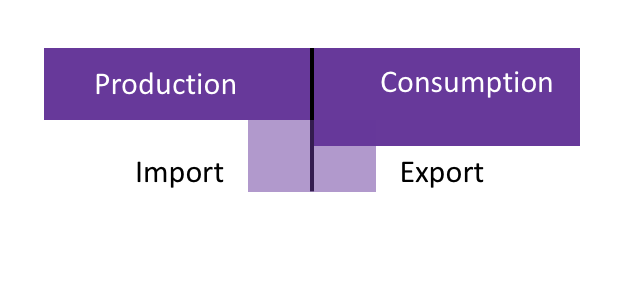

But it should be possible to support with minor changes to the Sankey diagram definition. For example, the difference between this style and the style shown above could be requested by changing:

```python
Bundle(Elsewhere, 'b', waypoints=['imports'])
```
to
```python
Bundle(Elsewhere, 'b', waypoints=[])
```

The lack of a waypoint would indicate that the flow should be shown as a short "stub".

## 2 - Forwards & backwards flows

This recipe demonstrates how forwards and backwards flows work.

For demonstration, the CSV data is written directly in the cell below -- in practice you would want to load data a file.

In [ ]:
flows = pd.read_csv(StringIO("""
source,target,type,value
a,b,main,2
a,c,main,1
c,d,main,3
b,c,back,2
"""))

flows

Here is one structure, with nodes `b` and `c` both in the same vertical slice:

In [ ]:
nodes = {
    'a': ProcessGroup(['a']),
    'b': ProcessGroup(['b']),
    'c': ProcessGroup(['c']),
    'd': ProcessGroup(['d']),
    'back': Waypoint(direction='L'),
}

bundles = [
    Bundle('a', 'b'),
    Bundle('a', 'c'),
    Bundle('b', 'c', waypoints=['back']),
    Bundle('c', 'd'),
    Bundle('c', 'b'),
]

ordering = [
    [['a'], []],
    [['b', 'c'], ['back']],
    [['d'], []],
]

sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows).to_widget(**size)

Alternatively, if `b` is moved to the right, extra hidden waypoints are automatically added to get the `b--c` flow back to the left of `c`:

In [ ]:
bundles = [
    Bundle('a', 'b'),
    Bundle('a', 'c'),
    Bundle('b', 'c'),
    Bundle('c', 'd'),
    Bundle('c', 'b'),
]

ordering = [
    [['a'], []],
    [['c'], ['back']],
    [['b', 'd'], []],
]

sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows).to_widget(**size)

## 3 - "Fruit" example (from Hybrid Sankey diagrams paper)

This notebook gives a fairly complicated example of building a Sankey diagram from the sample "fruit" database used in the paper [Hybrid Sankey diagrams: Visual analysis of multidimensional data for understanding resource use](https://doi.org/10.1016/j.resconrec.2017.05.002).

For more explanation of the steps and concepts, see the [tutorials](../tutorials/index.ipynb).

In [ ]:
# Load dataset
dataset = Dataset.from_csv('example_data/fruit_flows.csv', 'example_data/fruit_processes.csv')

This made-up dataset describes flows from farms to consumers:

In [ ]:
dataset._flows.head()

Additional information is available in the process dimension table:

In [ ]:
dataset._dim_process.head()

We'll also define some partitions that will be useful:

In [ ]:
farm_ids = ['farm{}'.format(i) for i in range(1, 16)]

farm_partition_5 = Partition.Simple('process', [('Other farms', farm_ids[5:])] + farm_ids[:5])
partition_fruit = Partition.Simple('material', ['bananas', 'apples', 'oranges'])
partition_sector = Partition.Simple('process.sector', ['government', 'industry', 'domestic'])

Now define the Sankey diagram definition.

- Process groups represent sets of processes in the underlying database. The underlying processes can be specified as a list of ids (e.g. `['inputs']`) or as a Pandas query expression (e.g. `'function == "landfill"'`).
- Waypoints allow extra control over the partitioning and placement of flows.

In [ ]:
nodes = {
    'inputs':     ProcessGroup(['inputs'], title='Inputs'),
    'compost':    ProcessGroup('function == "composting stock"', title='Compost'),
    'farms':      ProcessGroup('function in ["allotment", "large farm", "small farm"]', farm_partition_5),
    'eat':        ProcessGroup('function == "consumers" and location != "London"', partition_sector,
                               title='consumers by sector'),
    'landfill':   ProcessGroup('function == "landfill" and location != "London"', title='Landfill'),
    'composting': ProcessGroup('function == "composting process" and location != "London"', title='Composting'),

    'fruit':        Waypoint(partition_fruit, title='fruit type'),
    'w1':           Waypoint(direction='L', title=''),
    'w2':           Waypoint(direction='L', title=''),
    'export fruit': Waypoint(Partition.Simple('material', ['apples', 'bananas', 'oranges'])),
    'exports':      Waypoint(title='Exports'),
}

The ordering defines how the process groups and waypoints are arranged in the final diagram. It is structured as a list of vertical *layers* (from left to right), each containing a list of horizontal *bands* (from top to bottom), each containing a list of process group and waypoint ids (from top to bottom).

In [ ]:
ordering = [
    [[], ['inputs', 'compost'], []],
    [[], ['farms'], ['w2']],
    [['exports'], ['fruit'], []],
    [[], ['eat'], []],
    [['export fruit'], ['landfill', 'composting'], ['w1']],
]

Bundles represent flows in the underlying database:

In [ ]:
bundles = [
    Bundle('inputs', 'farms'),
    Bundle('compost', 'farms'),
    Bundle('farms', 'eat', waypoints=['fruit']),
    Bundle('farms', 'compost', waypoints=['w2']),
    Bundle('eat', 'landfill'),
    Bundle('eat', 'composting'),
    Bundle('composting', 'compost', waypoints=['w1', 'w2']),
    Bundle('farms', Elsewhere, waypoints=['exports', 'export fruit']),
]

Finally, the process groups, waypoints, bundles and ordering are combined into a Sankey diagram definition (SDD). When applied to the dataset, the result is a Sankey diagram!

In [ ]:
sdd = SankeyDefinition(nodes, bundles, ordering,
                       flow_partition=dataset.partition('material'))
weave(sdd, dataset) \
    .to_widget(width=570, height=550, margins=dict(left=70, right=90))

# Setting the scale

This recipe demonstrates how the scale of the Sankey diagram is set.

By default the scale is calculated for each diagram to achieve a certain whitespace-to-flow ratio within the height that is given. But in some cases, you may want to set the scale explicitly.

For demonstration, the CSV data is written directly in the cell below -- in practice you would want to load data a file.

In [ ]:
flows = pd.read_csv(StringIO("""
year,source,target,value
2020,A,B,10
2025,A,B,20
"""))

flows

In [ ]:
nodes = {
    'A': ProcessGroup(['A']),
    'B': ProcessGroup(['B']),
}

bundles = [
    Bundle('A', 'B'),
]

ordering = [['A'], ['B']]

sdd = SankeyDefinition(nodes, bundles, ordering)

If we draw the flow for the year 2020 and the year 2025 separately, they appear the same:

In [ ]:
w1 = weave(sdd, flows.query('year == 2020')).to_widget(**size)
w1

In [ ]:
w2 = weave(sdd, flows.query('year == 2025')).to_widget(**size)
w2

But in fact they have different scales:

In [ ]:
w1.scale, w2.scale

The units of the scale are `units-of-value` per pixel.

If we draw the Sankeys again while setting the scale, we can see that the flow indeed has changed between years:

In [ ]:
SCALE = 2.0

w1 = weave(sdd, flows.query('year == 2020')).to_widget(**size)
w2 = weave(sdd, flows.query('year == 2025')).to_widget(**size)

w1.scale = w2.scale = SCALE

HBox([w1, w2])